,dataset,scan_id,sample,energy,pol
0,"<None>, 433 points","CCD Scan 83731,CCD Scan 83784",ZnPc_40nm,250.0,sp
0,"<None>, 171 points","CCD Scan 83715,CCD Scan 83717",ZnPc_20nm,250.0,sp


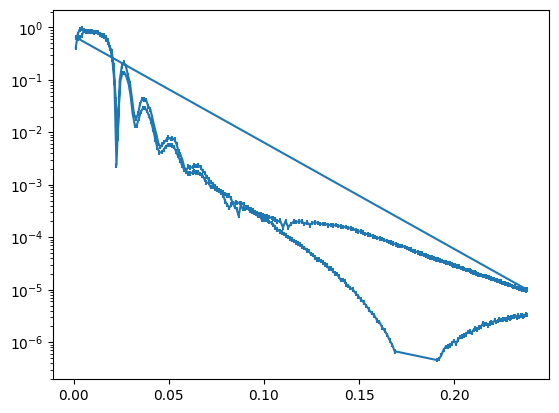

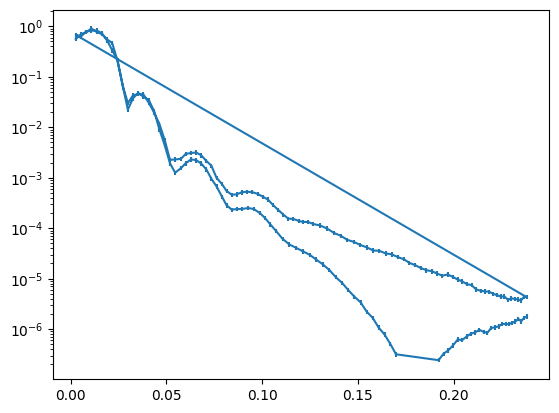

In [58]:
import pandas as pd
import pickle as pkl
import matplotlib.pyplot as plt
from pathlib import Path

from refnx.dataset import ReflectDataset
import pyref as ref

data_path = beamtime = Path(
    "C:/Users/hduva/Washington State University (email.wsu.edu)/Carbon Lab Research Group - Documents/Synchrotron Logistics and Data/ALS - Berkeley/Data/BL1101/2024Apr/XRR/Processed"
)

data: pd.DataFrame = pkl.load(open(data_path / "data.pkl", "rb"))
data.sort_values("energy", inplace=True)

# select the 250 eV, sp pol data

data_250 = data[(data["energy"] == 250) & (data["pol"] == "sp")]
display(data_250)

# Print some data

for i, row in data_250.iterrows():
    # Load the data
    data = row["dataset"]
    data.plot()
    plt.yscale("log")

________________________________________________________________________________
Parameters: 'Structure - ZNPC_250eV'
________________________________________________________________________________
Parameters:      'Vac'     
<Parameter:  'Vac_thick'  , value=0  (fixed) , bounds=[-inf, inf]>
<Parameter:     'rho'     , value=0  (fixed) , bounds=[-inf, inf]>
<Parameter:  'Vac_rough'  , value=0  (fixed) , bounds=[-inf, inf]>
________________________________________________________________________________
Parameters:     'ZNPC'     
<Parameter: 'ZNPC_thick'  , value=196.441          , bounds=[96.441, 296.44100000000003]>
<Parameter:     'rho'     , value=1.3742          , bounds=[1.5, 1.7]>
<Parameter: 'ZNPC_rough'  , value=7.21628          , bounds=[1.0, 100.0]>
________________________________________________________________________________
Parameters:       'C'      
<Parameter:   'C_thick'   , value=6.08          , bounds=[5.0, 10.0]>
<Parameter:     'rho'     , value=1.939          

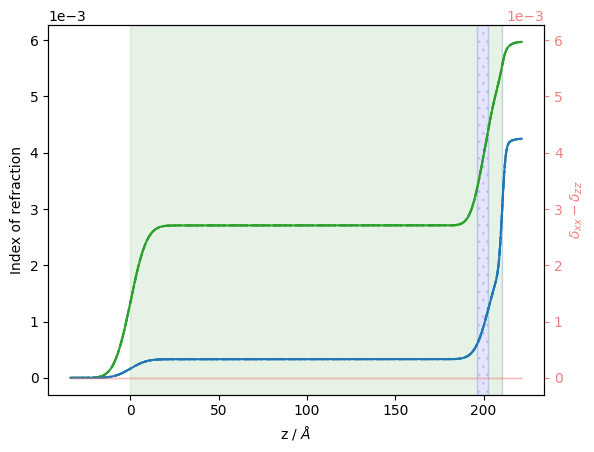

In [59]:
import glob
from pypxr.structure import PXR_MaterialSLD, PXR_Structure

thick_znpc = 196.441
thick_c = 6.08
thick_o2 = 8

density_znpc = 1.3742
density_c = 1.939
density_o2 = 2.1465

rough_znpc = 7.21628
rough_c = 4.4
rough_o2 = 6.383
rough_si = 1.5

def generate_structure(energy, bulk_thick = thick_znpc, bulk_rough = rough_znpc) -> PXR_Structure:

    vac = PXR_MaterialSLD("", 0, energy, name="Vac")(0,0)
    znpc = PXR_MaterialSLD("C32H16N8Zn1", density_znpc, energy, name="ZNPC")(bulk_thick, bulk_rough)
    c = PXR_MaterialSLD("C", density_c, energy, name="C")(thick_c, rough_c)
    o2 = PXR_MaterialSLD("SiO2", density_o2, energy, name="O2")(thick_o2, rough_o2)
    si = PXR_MaterialSLD("Si", 2.33, energy, name="Si")(0, rough_si)

    si.rough.setp(vary=True, bounds=(1, 10))
    si.sld.density.setp(vary=True, bounds=(2.2, 2.5))

    o2.rough.setp(vary=True, bounds=(1, 10))
    o2.thick.setp(vary=True, bounds=(5, 10))
    o2.sld.density.setp(vary=True, bounds=(2.1, 2.2))

    c.rough.setp(vary=True, bounds=(1, 10))
    c.thick.setp(vary=True, bounds=(5, 10))
    c.sld.density.setp(vary=True, bounds=(1.8, 2.2))

    znpc.rough.setp(vary=True, bounds=(1, 100))
    znpc.thick.setp(vary=True, bounds=(bulk_thick-100, bulk_thick+100))
    znpc.sld.density.setp(vary=True, bounds=(1.5, 1.7))

    structure: PXR_Structure = vac | znpc | c | o2 | si
    structure.name = f"ZNPC_{energy}eV"
    return structure
# Example of generating a structure
structure = generate_structure(250)
structure.plot(difference=True)
print(structure.parameters)

________________________________________________________________________________
Parameters: 'Model - ZNPC_250eV'
________________________________________________________________________________
Parameters: 'instrument parameters'
<Parameter:'dq - resolution', value=0  (fixed) , bounds=[-inf, inf]>
<Parameter:  'q_offset'   , value=0  (fixed) , bounds=[-inf, inf]>
<Parameter:  'en_offset'  , value=0  (fixed) , bounds=[-inf, inf]>
<Parameter:     'bkg'     , value=0  (fixed) , bounds=[-inf, inf]>
<Parameter:   'scale_s'   , value=1          , bounds=[0.6, 1.2]>
<Parameter:   'scale_p'   , value=1          , bounds=[0.6, 1.2]>
<Parameter:'theta_offset_s', value=0.5          , bounds=[-1.0, 1.0]>
<Parameter:'theta_offset_p', value=-0.5          , bounds=[-1.0, 1.0]>
________________________________________________________________________________
Parameters: 'Structure - ZNPC_250eV'
________________________________________________________________________________
Parameters:      'Vac'     

(<Figure size 640x480 with 1 Axes>, <Axes: >)

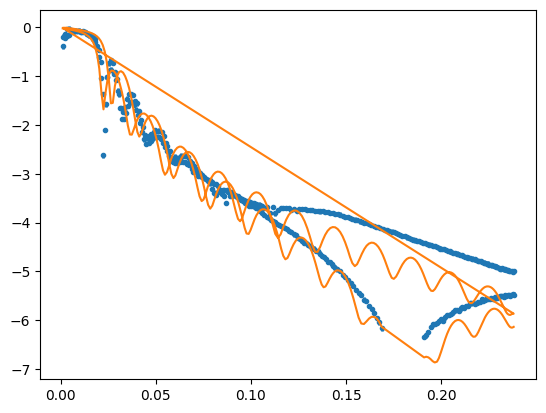

In [60]:
from pyref.fitting.logp import LogpExtra_rough as LogpExtra
from pypxr.reflectivity import PXR_ReflectModel
from refnx.analysis import Objective, Transform, CurveFitter


def generate_objective(data:ReflectDataset, energy: float, bulk_thick = thick_znpc, bulk_rough = rough_znpc):
    structure = generate_structure(energy, bulk_thick = bulk_thick, bulk_rough = bulk_rough)
    model = PXR_ReflectModel(
        structure,
        pol="sp",
        energy=energy,
        theta_offset={"s": 0.5, "p": -0.5},
        name = f"Model - ZNPC_{energy}eV"
    )
    model.scale_s.setp(vary = True, bounds = (0.6, 1.2))
    model.scale_p.setp(vary = True, bounds = (0.6, 1.2))
    model.theta_offset_s.setp(vary = True, bounds = (-1, 1))
    model.theta_offset_p.setp(vary = True, bounds = (-1, 1))

    objective = Objective(model, data, transform=Transform("logY"), name = f"Objective - ZNPC_{energy}eV")
    lpe = LogpExtra(objective)
    objective.logp_extra = lpe
    return objective, structure

obj, _ = generate_objective(data_250.iloc[0]["dataset"], 250, bulk_thick = 300)
print(obj.parameters)
obj.plot()

In [61]:
from ipywidgets import interact

@interact(thick = (100, 500, 10), rough = (1, 100, 1))
def plot_structure(thick, rough):
    obj, structure = generate_objective(data_250.iloc[1]["dataset"], 250, bulk_thick = thick, bulk_rough = rough)
    obj.plot()
    plt.show()

interactive(children=(IntSlider(value=300, description='thick', max=500, min=100, step=10), IntSlider(value=50…

# Running The Fitting Analysis

In [70]:
import numpy as np
from typing import Literal
from refnx._lib.emcee.moves.de import DEMove


class Fitter:
    # Suppresses the warning
    from warnings import simplefilter

    simplefilter("ignore")

    def __init__(self, obj: Objective, en, burn_in=0, write_dir: Path | None = None):
        self.obj = obj
        self.move = [
            (DEMove(sigma=1e-7), 0.90),
            (DEMove(sigma=1e-7, gamma0=1), 0.1),
        ]
        if obj.__class__.__name__ == "GlobalObjective":
            self.n_params = sum(
                [
                    len(o.data.data[0]) - len(o.varying_parameters())
                    for o in obj.objectives
                ]
            )
        else:
            self.n_params = len(self.obj.varying_parameters())
        self._n_walkers = 10 * len(self.obj.varying_parameters())
        self.burn_in = burn_in
        self.fitter = CurveFitter(obj, nwalkers=self._n_walkers, moves=self.move)
        self.en = en
        self.write_dir = write_dir

    @property
    def n_walkers(self):
        return self._n_walkers

    @n_walkers.setter
    def n_walkers(self, value):
        self._n_walkers = value
        self.fitter = CurveFitter(self.obj, nwalkers=self._n_walkers, moves=self.move)

    def red_chisqr(self):
        try:
            return self.obj.chisqr() / self.n_params
        except:
            return np.nan

    def fit(
        self,
        steps_per_param=20,
        thin=1,
        seed=1,
        init: Literal["jitter", "prior"] = "jitter",
        show_output=False,
    ):
        print(f"Reduced χ2 = {self.red_chisqr()}")
        steps = steps_per_param * self.n_params
        burn = int(steps * self.burn_in)

        self.fitter.initialise(init, random_state=seed)
        self.chain = self.fitter.sample(
            steps,
            random_state=seed,
            nthin=thin,
            skip_initial_state_check=True,
            nburn=burn,
            pool=10,
        )
        if show_output:
            self.show_output()
            file_name = (
                self.write_dir / f"{self.en}.pkl"
                if self.write_dir
                else f"{self.en}.pkl"
            )
            self.export(file_name)

    def show_output(self):
        print(self.obj.varying_parameters())
        fig, ax = plt.subplots()
        lp = self.fitter.logpost
        ax.plot(-lp)
        plt.show()
        if self.obj.__class__.__name__ == "GlobalObjective":
            for o in self.obj.objectives:
                o.plot(resid=True)
                plt.show()
        else:
            self.obj.plot(resid=True)
            plt.show()
        self.export(f"{self.en}.pkl")

    def export(self, filename: str):
        with open(filename, "wb") as f:
            pkl.dump(self, f)

    def delete_obj(self):
        del self


Reduced χ2 = 2477.0626491036373


100%|██████████| 600/600 [04:44<00:00,  2.11it/s]

________________________________________________________________________________
Parameters:      None      
<Parameter:   'scale_s'   , value=0.999994 +/- 0.000104, bounds=[0.6, 1.2]>
<Parameter:   'scale_p'   , value=1.00002 +/- 0.000106, bounds=[0.6, 1.2]>
<Parameter:'theta_offset_s', value=0.500005 +/- 4.9e-05, bounds=[-1.0, 1.0]>
<Parameter:'theta_offset_p', value=-0.500007 +/- 4.79e-05, bounds=[-1.0, 1.0]>
<Parameter: 'ZNPC_thick'  , value=299.997 +/- 0.0304, bounds=[200.0, 400.0]>
<Parameter:     'rho'     , value=1.59611 +/- 0.0736, bounds=[1.5, 1.7]>
<Parameter: 'ZNPC_rough'  , value=20 +/- 0.00198, bounds=[1.0, 100.0]>
<Parameter:   'C_thick'   , value=6.07999 +/- 0.000587, bounds=[5.0, 10.0]>
<Parameter:     'rho'     , value=1.93901 +/- 0.000214, bounds=[1.8, 2.2]>
<Parameter:   'C_rough'   , value=4.39996 +/- 0.000448, bounds=[1.0, 10.0]>
<Parameter:  'O2_thick'   , value=7.99987 +/- 0.000868, bounds=[5.0, 10.0]>
<Parameter:     'rho'     , value=2.1465 +/- 0.000208, bound

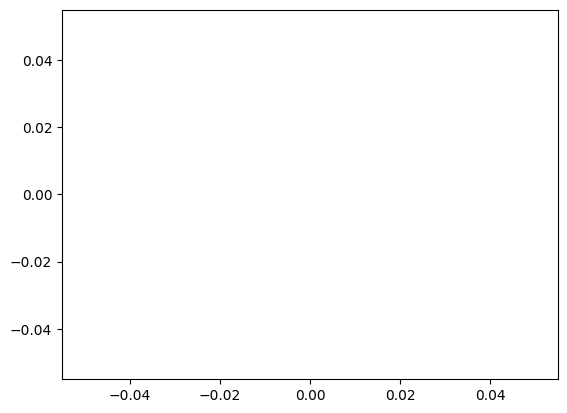

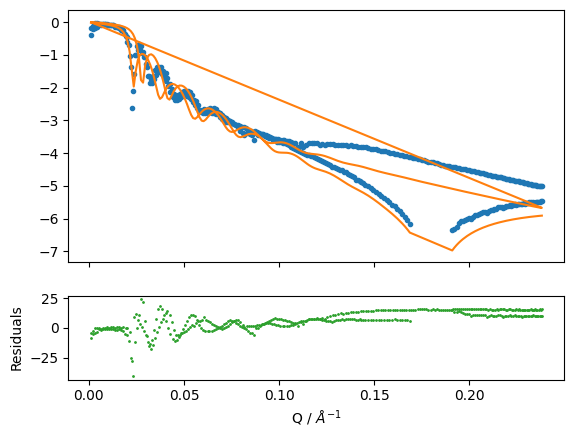

Reduced χ2 = 278.27311226596015


100%|██████████| 600/600 [02:46<00:00,  3.61it/s]


________________________________________________________________________________
Parameters:      None      
<Parameter:   'scale_s'   , value=0.999994 +/- 0.000104, bounds=[0.6, 1.2]>
<Parameter:   'scale_p'   , value=1.00002 +/- 0.000106, bounds=[0.6, 1.2]>
<Parameter:'theta_offset_s', value=0.500005 +/- 4.9e-05, bounds=[-1.0, 1.0]>
<Parameter:'theta_offset_p', value=-0.500007 +/- 4.79e-05, bounds=[-1.0, 1.0]>
<Parameter: 'ZNPC_thick'  , value=299.997 +/- 0.0304, bounds=[200.0, 400.0]>
<Parameter:     'rho'     , value=1.58159 +/- 0.0654, bounds=[1.5, 1.7]>
<Parameter: 'ZNPC_rough'  , value=20 +/- 0.00198, bounds=[1.0, 100.0]>
<Parameter:   'C_thick'   , value=6.07999 +/- 0.000587, bounds=[5.0, 10.0]>
<Parameter:     'rho'     , value=1.93901 +/- 0.000214, bounds=[1.8, 2.2]>
<Parameter:   'C_rough'   , value=4.39996 +/- 0.000448, bounds=[1.0, 10.0]>
<Parameter:  'O2_thick'   , value=7.99987 +/- 0.000868, bounds=[5.0, 10.0]>
<Parameter:     'rho'     , value=2.1465 +/- 0.000208, bound

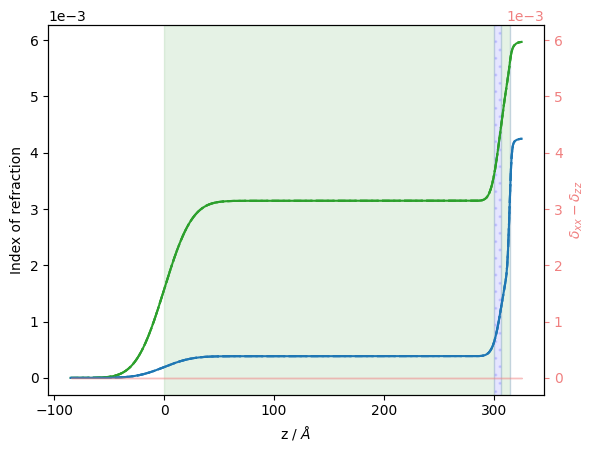

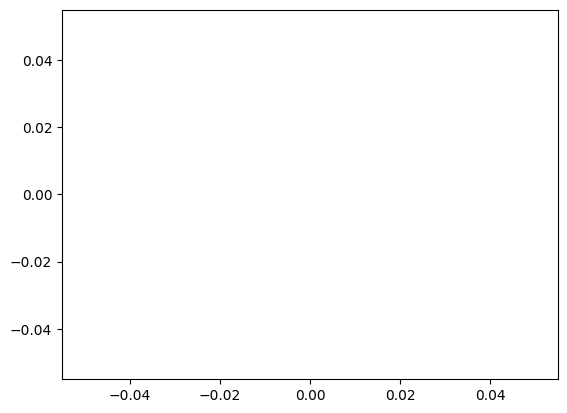

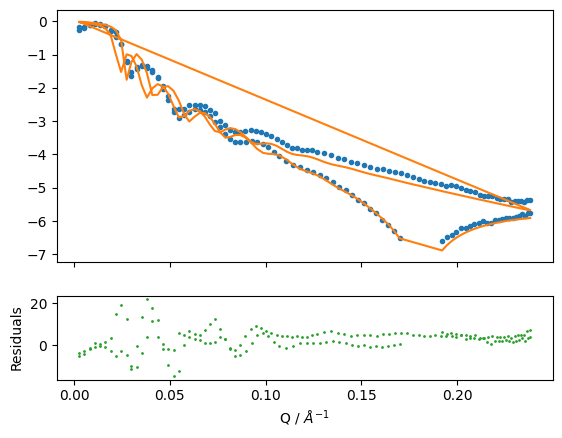

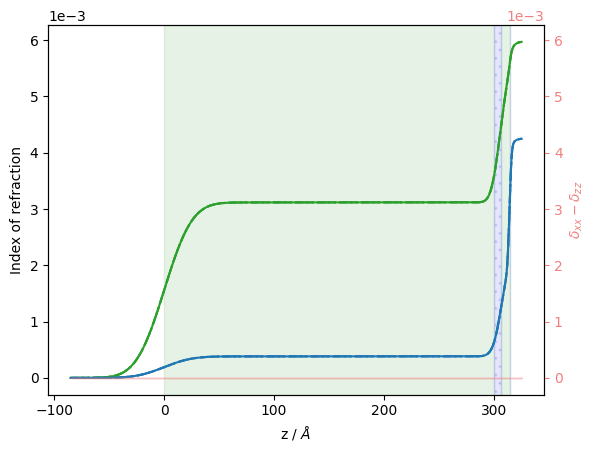

In [71]:
def fit_objective(data: pd.DataFrame):
    thick = 300, 200
    rough = 20, 20
    fitters = []
    for i, row in data.iterrows():
        energy = row["energy"]
        dataset = row["dataset"]
        obj, struc = generate_objective(dataset, energy, bulk_thick=thick[i], bulk_rough=rough[i])
        fitter = Fitter(obj, energy)
        fitter.fit(thin=2, show_output=True)
        struc.plot(difference=True)
        fitters.append(fitter)
    return fitters

fitters = fit_objective(data_250)